# ベジエ曲線による近似の次数による違いを比較

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



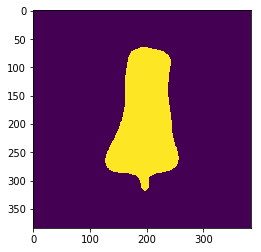

In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

In [12]:
def threeLinesSeqR2(src, showImage =  False, n_samples=20, N=4, debugmode=False, mode=2): 
    _img,contours,hierarchy = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    x0,y0,w,h = cv2.boundingRect(src)
    cnt = contours[0]
    canvas = np.zeros_like(src)
    # 輪郭線の描画
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
    # 取り囲む矩形を得る

    # 仮の中心軸を決めるために左右の輪郭のサンプル点を選ぶ
    def getRLlines(): 
        # 上下端それぞれ5％は歪みが大きいので一旦カット   
        cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
        cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置
        canvas[0:cut05,:]=np.zeros((cut05,src.shape[1]))
        canvas[cut95+1:,:]=np.zeros((src.shape[0]-(cut95+1),src.shape[1]))
    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        return cntl,cntr
    cntl,cntr = getRLlines()

    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    #datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=4,mode=4,debugmode=False)
    datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
    # precPara=0.01,order=5,mode=5,debugmode=False
    datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
    bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2

    # 結果の描画
    if showImage:
        tplinsOver = np.linspace(-0.03, 1.03,55)
        tplinsLong = np.linspace(-0.3, 1.3,50)
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
        plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
        plot20cx = [bezXc.subs(t,tp) for tp in tplins20 ]
        plot20cy = [bezYc.subs(t,tp) for tp in tplins20 ]
        plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
        plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        
        # plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #     


# 両端固定モード

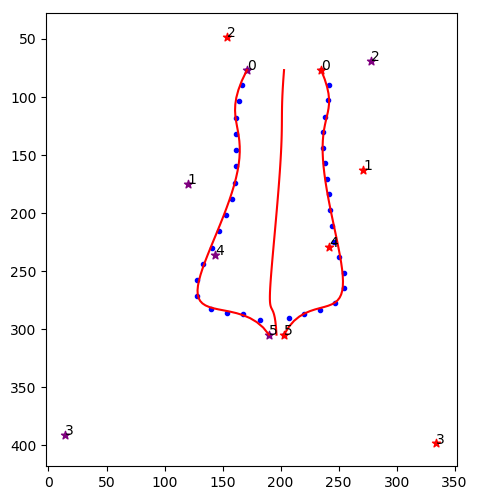

In [3]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=5)

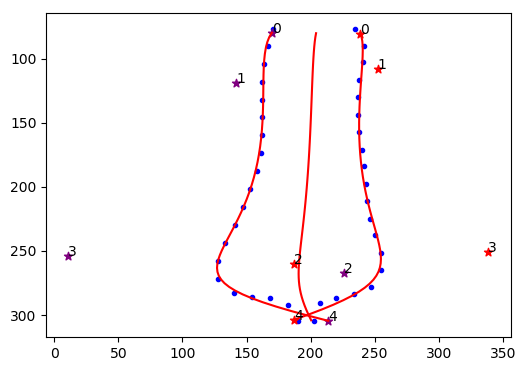

In [344]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=4)

# 両端フリーモード

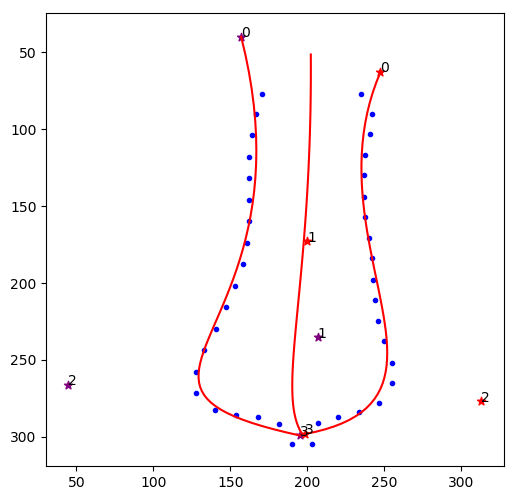

In [345]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=3)

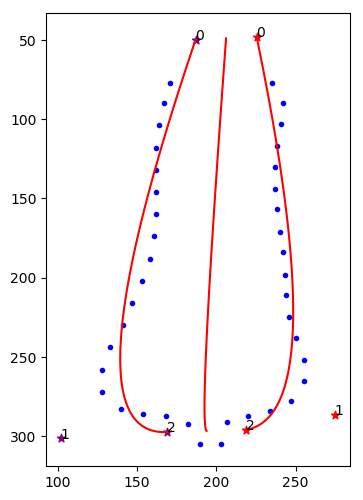

In [346]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=2)

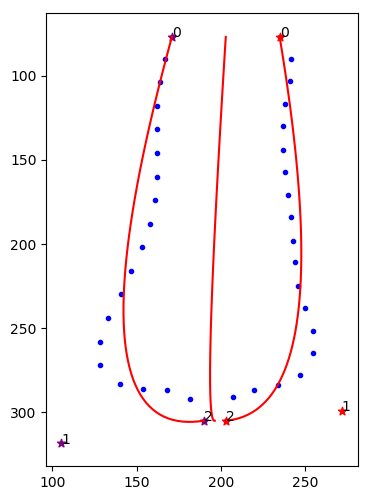

In [349]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=2,mode=2)

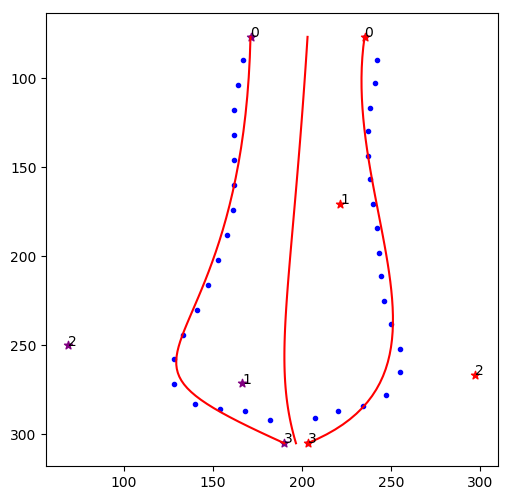

In [353]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=3,mode=2)

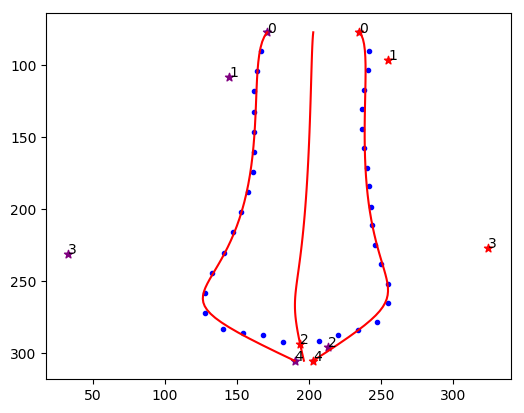

In [351]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=4,mode=2)

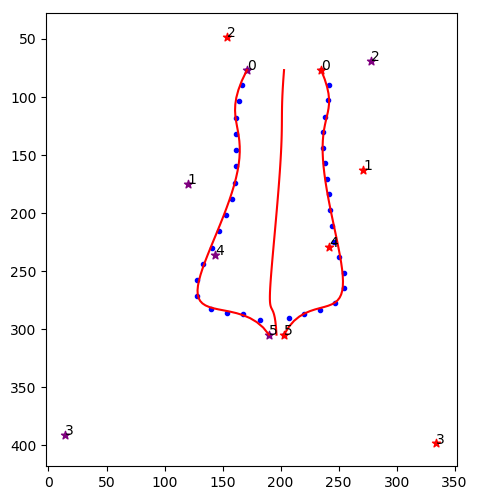

In [352]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=5,mode=2)

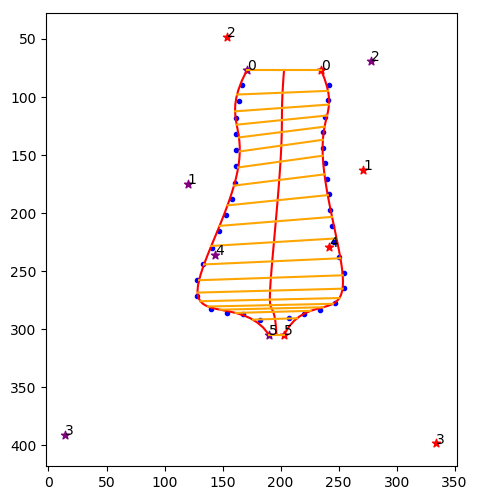

In [13]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)

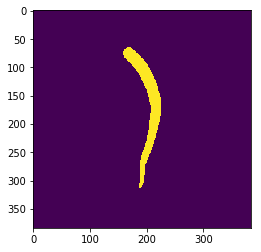

In [14]:
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

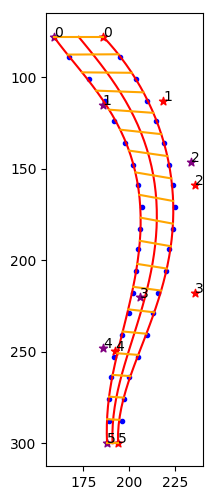

In [15]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)

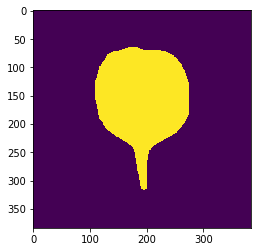

In [16]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

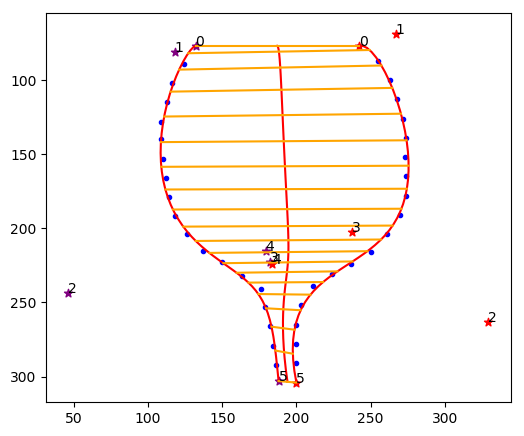

In [17]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)